In [22]:
# Import the required libraries
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from scipy.optimize import minimize

In [23]:
# Define assets by category
assets = {
    'Bond universe': ["IEF", "TLT", "AGG", "BND", "TIP"],
}


In [24]:
# Create an empty DataFrame to store the information
columns = ['Ticker', 'Name', 'Description', 'Recent Yield']
df = pd.DataFrame(columns=columns)

# Fetch and store data for each instrument
for category, tickers in assets.items():
    for ticker in tickers:
        # Fetch ticker information
        ticker_info = yf.Ticker(ticker).info
        # Extract relevant information
        name = ticker_info.get('shortName', 'N/A')
        description = ticker_info.get('longBusinessSummary', 'N/A')
        recent_yield = ticker_info.get('yield', 'N/A')
        # Create a DataFrame for the current ticker
        temp_df = pd.DataFrame({
            'Ticker': [ticker],
            'Name': [name],
            'Description': [description],
            'Recent Yield': [recent_yield]
        })
        # Concatenate the temporary DataFrame with the main DataFrame
        df = pd.concat([df, temp_df], ignore_index=True)

# Display the DataFrame
print(df)

# Save the DataFrame to an Excel file for better readability
# df.to_excel("bond_universe_info.xlsx", index=False)

  Ticker                             Name  \
0    IEF  iShares 7-10 Year Treasury Bond   
1    TLT  iShares 20+ Year Treasury Bond    
2    AGG  iShares Core U.S. Aggregate Bon   
3    BND   Vanguard Total Bond Market ETF   
4    TIP            iShares TIPS Bond ETF   

                                         Description  Recent Yield  
0  The underlying index measures the performance ...        0.0323  
1  The fund will invest at least 80% of its asset...        0.0387  
2  The index measures the performance of the tota...        0.0341  
3  This index measures the performance of a wide ...        0.0337  
4  The index tracks the performance of inflation-...        0.0281  


In [25]:
# Fetch historical stock data from Yahoo Finance
start_date = "2024-01-01"
end_date = "2024-06-01"
data = {}
for category, tickers in assets.items():
    data[category] = {ticker: yf.download(ticker, start=start_date, end=end_date)['Adj Close'] for ticker in tickers}

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


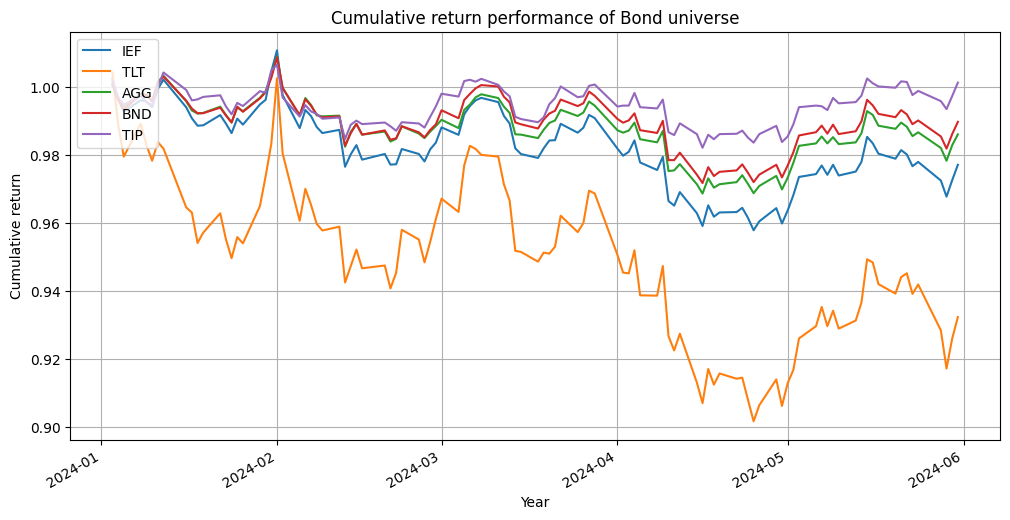

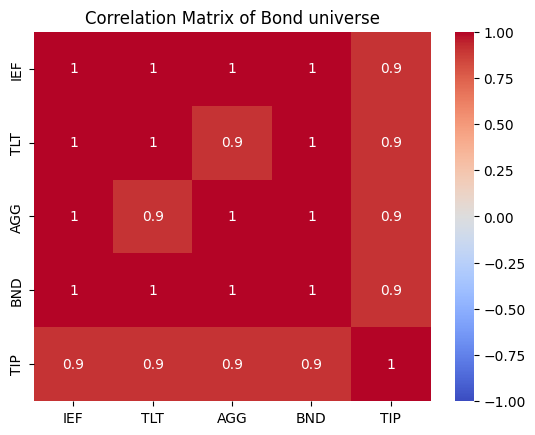


Statistical Data for Bond universe:

                         IEF       TLT       AGG       BND       TIP
Mean               -0.000214 -0.000638 -0.000129 -0.000094  0.000017
Standard Deviation  0.004378  0.008593  0.003587  0.003559  0.003149
Sharpe Ratio       -0.048837 -0.074230 -0.036053 -0.026289  0.005267

--------------------------------------------------



In [26]:
# Process and plot data for each category
for category, datasets in data.items():
    df = pd.DataFrame(datasets).dropna()
    daily_returns = df.pct_change().dropna()
    cumulative_returns = (1 + daily_returns).cumprod()

    # Plot Cumulative Return Performance
    cumulative_returns.plot(figsize=(12, 6), title=f"Cumulative return performance of {category}")
    plt.ylabel("Cumulative return")
    plt.xlabel("Year")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

    # Plot correlation matrix if more than one ticker in the category
    if len(datasets) > 1:
        corr_matrix = daily_returns.corr().round(1)
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title(f"Correlation Matrix of {category}")
        plt.show()

    # Compute Sharpe Ratio (Assuming risk-free rate is 0 for simplicity)
    stats = pd.DataFrame(index=["Mean", "Standard Deviation", "Sharpe Ratio"])
    daily_returns = pd.DataFrame(datasets).pct_change().dropna()
    for ticker in datasets:
        stats[ticker] = [
            daily_returns[ticker].mean(),
            daily_returns[ticker].std(),
            daily_returns[ticker].mean() / daily_returns[ticker].std() if daily_returns[ticker].std() != 0 else np.nan
        ]
    print(f"\nStatistical Data for {category}:\n")
    print(stats)
    print("\n" + "-" * 50 + "\n")

In [27]:
# Fetch yield data for different maturities
yield_tickers = ["^IRX", "^FVX", "^TNX", "^TYX"]
yield_data = {ticker: yf.download(ticker, start=start_date, end=end_date)['Adj Close'] for ticker in yield_tickers}

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [28]:
# Calculate yield spreads
yield_df = pd.DataFrame(yield_data).dropna()
yield_df.columns = ["3M", "5Y", "10Y", "30Y"]

# Compute spreads (e.g., 10Y - 2Y spread)
yield_df["10Y-3M spread"] = yield_df["10Y"] - yield_df["3M"]
yield_df["10Y-5Y spread"] = yield_df["10Y"] - yield_df["5Y"]
yield_df["30Y-10Y spread"] = yield_df["30Y"] - yield_df["10Y"]
yield_df["30Y-5Y spread"] = yield_df["30Y"] - yield_df["5Y"]

# Plot yield curves
fig = make_subplots(rows=1, cols=1, subplot_titles=["Yield curves"])
for column in yield_df.columns[:-2]:  # exclude spread columns
    fig.add_trace(go.Scatter(x=yield_df.index, y=yield_df[column], mode='lines', name=column), row=1, col=1)

fig.update_layout(title="US Treasury yield curves", xaxis_title="Date", yaxis_title="Yield (%)")
fig.show()

In [29]:
# Plot spreads
fig = make_subplots(rows=1, cols=1, subplot_titles=["Yield preads"])
fig.add_trace(go.Scatter(x=yield_df.index, y=yield_df["10Y-3M spread"], mode='lines', name="10Y-3M spread"), row=1, col=1)
fig.add_trace(go.Scatter(x=yield_df.index, y=yield_df["10Y-5Y spread"], mode='lines', name="10Y-5Y spread"), row=1, col=1)
fig.add_trace(go.Scatter(x=yield_df.index, y=yield_df["30Y-10Y spread"], mode='lines', name="30Y-10Y spread"), row=1, col=1)
fig.add_trace(go.Scatter(x=yield_df.index, y=yield_df["30Y-5Y spread"], mode='lines', name="30Y-5Y spread"), row=1, col=1)

fig.update_layout(title="US Treasury yield spreads", xaxis_title="Date", yaxis_title="Spread (bps)")
fig.show()

In [30]:
# Rolling average for spreads
yield_df["10Y-3M spread rolling avg"] = yield_df["10Y-3M spread"].rolling(window=7).mean()
yield_df["10Y-5Y spread rolling avg"] = yield_df["10Y-5Y spread"].rolling(window=7).mean()

# Plot rolling average of spreads
fig = make_subplots(rows=1, cols=1, subplot_titles=["Rolling average of yield spreads"])
fig.add_trace(go.Scatter(x=yield_df.index, y=yield_df["10Y-3M spread rolling avg"], mode='lines', name="10Y-3M spread rolling avg"), row=1, col=1)
fig.add_trace(go.Scatter(x=yield_df.index, y=yield_df["10Y-5Y spread rolling avg"], mode='lines', name="10Y-5Y spread rolling avg"), row=1, col=1)

fig.update_layout(title="Rolling average of US Treasury yield spreads", xaxis_title="Date", yaxis_title="Spread (bps)")
fig.show()

In [31]:
# Define a function to compute duration
def compute_duration(cashflows, times, ytm):
    pv_factors = [(1 + ytm) ** -t for t in times]
    weighted_cf = [cf * pvf for cf, pvf in zip(cashflows, pv_factors)]
    duration = sum(t * wcf for t, wcf in zip(times, weighted_cf)) / sum(weighted_cf)
    return duration

# Define a function to compute convexity
def compute_convexity(cashflows, times, ytm):
    pv_factors = [(1 + ytm) ** -t for t in times]
    weighted_cf = [cf * pvf for cf, pvf in zip(cashflows, pv_factors)]
    convexity = sum(t * (t + 1) * wcf for t, wcf in zip(times, weighted_cf)) / ((1 + ytm)**2 * sum(weighted_cf))
    return convexity

# Define a function to compute CVaR (Conditional Value at Risk)
def compute_cvar(returns, alpha=0.05):
    var = np.percentile(returns, 100 * alpha)
    cvar = returns[returns <= var].mean()
    return var, cvar

'''
# Define a function to fit the Nelson-Siegel yield curve
def nelson_siegel(params, maturities):
    beta0, beta1, beta2, tau = params
    factor1 = (1 - np.exp(-maturities / tau)) / (maturities / tau)
    factor2 = factor1 - np.exp(-maturities / tau)
    return beta0 + beta1 * factor1 + beta2 * factor2

# Define a function to optimize the Nelson-Siegel parameters
def fit_nelson_siegel(yields, maturities):
    initial_params = [0.03, -0.02, 0.02, 2.0]  # Initial guesses for the parameters
    result = minimize(lambda params: np.sum((nelson_siegel(params, maturities) - yields) ** 2),
                      initial_params, method='BFGS')
    return result.x
'''

# Define assets by category
assets = {
    'US Government Bonds': ["IEF", "TLT", "AGG", "BND", "TIP", "^IRX", "^FVX", "^TNX", "^TYX"],
}

# Fetch historical stock data from Yahoo Finance
start_date = "2023-01-01"
end_date = "2023-11-01"
data = {}
for category, tickers in assets.items():
    data[category] = {ticker: yf.download(ticker, start=start_date, end=end_date)['Adj Close'] for ticker in tickers}

    # Compute Duration, Convexity and CVaR for each bond ETF
    bond_durations = {}
    bond_convexities = {}
    bond_cvar = {}

    for ticker in datasets:
        ytm = daily_returns[ticker].mean() * 252  # Assuming 252 trading days in a year
        cashflows = [1] * 10  # Assuming fixed annual coupon payments of 1 for simplicity
        times = list(range(1, 11))  # Assuming a 10-year bond

        duration = compute_duration(cashflows, times, ytm)
        convexity = compute_convexity(cashflows, times, ytm)
        var, cvar = compute_cvar(daily_returns[ticker])

        bond_durations[ticker] = duration
        bond_convexities[ticker] = convexity
        bond_cvar[ticker] = cvar

    print(f"Durations for {category}: {bond_durations}")
    print(f"Convexities for {category}: {bond_convexities}")
    print(f"CVaR for {category}: {bond_cvar}")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Durations for US Government Bonds: {'IEF': 5.954628616787092, 'TLT': 6.876099443124268, 'AGG': 5.7728681386295175, 'BND': 5.696664624956271, 'TIP': 5.465589513371735}
Convexities for US Government Bonds: {'IEF': 55.33909225892557, 'TLT': 86.98598304740474, 'AGG': 50.54442616385227, 'BND': 48.64174717476428, 'TIP': 43.225430841102536}
CVaR for US Government Bonds: {'IEF': -0.010697709877950656, 'TLT': -0.019577462407260826, 'AGG': -0.008884590686184413, 'BND': -0.008532446499293836, 'TIP': -0.007301880465515331}
